## MLP를 이용한 Classification
###### 가상의 데이터 샘플을 분류하는 MLP 모델 구현

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
%matplotlib inline

#### Pseudo Data Generation

In [140]:
n_dim = 2

x_train, y_train = make_blobs(
    n_samples=200,
    n_features=n_dim,
    centers=[[1, 1], [-1, -1], [1, -1], [-1, 1]],
    shuffle=True,
    cluster_std=0.3
)
x_valid, y_valid = make_blobs(
    n_samples=50,
    n_features=n_dim,
    centers=[[1, 1], [-1, -1], [1, -1], [-1, 1]],
    shuffle=True,
    cluster_std=0.3
)
x_test, y_test = make_blobs(
    n_samples=50,
    n_features=n_dim,
    centers=[[1, 1], [-1, -1], [1, -1], [-1, 1]],
    shuffle=True,
    cluster_std=0.3
)

In [141]:
x_train[:10]

array([[-0.983947  ,  0.99253897],
       [ 0.8993946 , -1.26417562],
       [-0.77212438, -0.57381642],
       [ 0.75953745, -0.94677507],
       [-1.00879577, -1.02552239],
       [-0.77759336, -0.91826593],
       [-0.96310884, -1.16439723],
       [ 1.31558244,  0.62041688],
       [ 0.81840266,  1.16337921],
       [-1.35013011, -0.77643459]])

In [142]:
# Label mapping
y_train[y_train < 2] = 0
y_train[y_train >= 2] = 1

y_valid[y_valid < 2] = 0
y_valid[y_valid >= 2] = 1

y_test[y_test < 2] = 0
y_test[y_test >= 2] = 1

In [143]:
y_train[:10]

array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0])

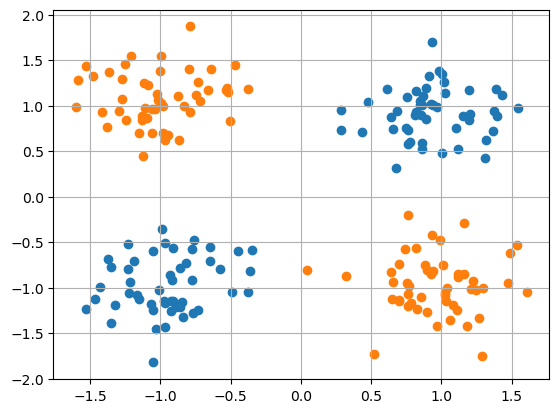

In [144]:
x_class_0 = x_train[y_train == 0]
x_class_1 = x_train[y_train == 1]

plt.scatter(x_class_0[:, 0], x_class_0[:, 1])
plt.scatter(x_class_1[:, 0], x_class_1[:, 1])

plt.grid()

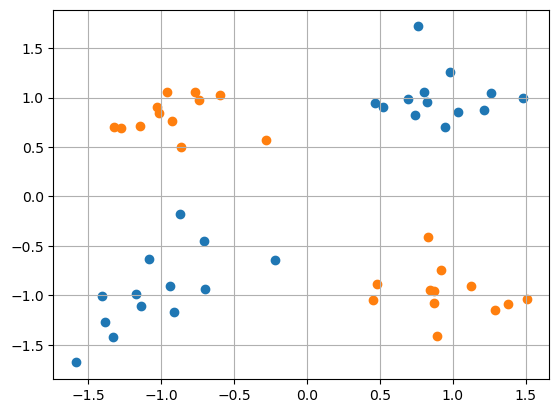

In [145]:
x_class_0 = x_valid[y_valid == 0]
x_class_1 = x_valid[y_valid == 1]

plt.scatter(x_class_0[:, 0], x_class_0[:, 1])
plt.scatter(x_class_1[:, 0], x_class_1[:, 1])

plt.grid()

#### Data Loader

In [146]:
import torch
from torch.utils.data import Dataset, DataLoader

In [147]:
class PseudoData(Dataset):
    
    def __init__(self, data_x, data_y=None):
        self.data_x = data_x.tolist()
        self.data_y = data_y
        if data_y is not None:
            self.data_y = data_y.tolist()
        
    def __len__(self):
        return len(self.data_x)
    
    def __getitem__(self, idx):
        sample = {}
        sample['x'] = self.data_x[idx]
        if self.data_y is not None:
            sample['y'] = self.data_y[idx]
        return sample

In [148]:
def collate_fn(batch):
    keys = [key for key in batch[0].keys()]
    data = {key: [] for key in keys}
    
    for item in batch:
        for key in keys:
            data[key].append(item[key])
    return data

In [149]:
batch = [
    {'x':[1, 2], 'y':0},
    {'x':[3, 4], 'y':1}
]
batch_cvted = {'x':[[1, 2], [3, 4]], 'y':[0, 1]}

In [150]:
collate_fn(batch)

{'x': [[1, 2], [3, 4]], 'y': [0, 1]}

In [151]:
train_dataset = PseudoData(x_train, y_train)
valid_dataset = PseudoData(x_valid, y_valid)
test_dataset = PseudoData(x_test, y_test)

# train dataloader만 shuffle 수행
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    collate_fn=collate_fn,
    shuffle=True
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=8,
    collate_fn=collate_fn,
    shuffle=False
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=8,
    collate_fn=collate_fn,
    shuffle=False
)

In [152]:
for batch in train_dataloader:
    print(batch)
    break

{'x': [[-1.068328450875974, -1.1843959334804084], [1.3779380557030818, 0.9432758783583565], [-1.2489230380531808, 1.4634230406995838], [-0.35914776238164103, -0.8219426693340178], [1.1600803906705466, -0.8539778358956835], [0.7460943569048659, 0.7605042225171871], [-1.3784417405224678, 0.7609543717913145], [-1.1133428129926828, 1.250361040542462]], 'y': [0, 0, 1, 0, 1, 0, 1, 1]}


In [153]:
batch['x'], batch['y']

([[-1.068328450875974, -1.1843959334804084],
  [1.3779380557030818, 0.9432758783583565],
  [-1.2489230380531808, 1.4634230406995838],
  [-0.35914776238164103, -0.8219426693340178],
  [1.1600803906705466, -0.8539778358956835],
  [0.7460943569048659, 0.7605042225171871],
  [-1.3784417405224678, 0.7609543717913145],
  [-1.1133428129926828, 1.250361040542462]],
 [0, 0, 1, 0, 1, 0, 1, 1])

#### Model

In [154]:
import torch
import torch.nn as nn
import torch.nn.init as init

In [155]:
class MLPClassification(nn.Module):
    
    def __init__(self, input_dim=2, hidden_size=32, output_dim=2):
        super().__init__()
        self.linear_1 = nn.Linear(input_dim, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, output_dim)
        
    def forward(self, x):
        h = torch.relu(self.linear_1(x))
        logit = self.linear_2(h)
        return logit

In [156]:
model = MLPClassification(input_dim=2, hidden_size=32, output_dim=2)

#### Training

In [157]:
import torch.optim as optim
import numpy as np
from copy import deepcopy

In [158]:
optimizer = optim.Adam(params=model.parameters(), lr=0.01)
calc_loss = nn.CrossEntropyLoss()

In [159]:
n_epoch = 20
global_i = 0

valid_loss_history, train_loss_history = [], []

min_valid_loss = 9e+9
best_model = None
best_epoch_i = None

In [160]:
for epoch_i in range(n_epoch):
    model.train()
    
    for batch in train_dataloader:
        optimizer.zero_grad()
        x = torch.tensor(batch['x'])
        y = torch.tensor(batch['y'])
        y_pred = model(x)
        loss = calc_loss(y_pred, y)
        
        if global_i % 10 == 0:
            print(f'global_i: {global_i}, epoch_i: {epoch_i}, loss: {loss.item()}')
        train_loss_history.append((global_i, loss.item()))
        
        loss.backward()
        optimizer.step()
        global_i += 1
        
    model.eval()
    
    # validation
    valid_loss_list = []
    for batch in valid_dataloader:
        x = torch.tensor(batch['x'])
        y = torch.tensor(batch['y'])
        y_pred = model(x)
        loss = calc_loss(y_pred, y)
        valid_loss_list.append(loss.item())
        
    valid_loss_mean = np.mean(valid_loss_list)
    valid_loss_history.append((global_i, valid_loss_mean.item()))
    
    if valid_loss_mean < min_valid_loss:
        min_valid_loss = valid_loss_mean
        best_epoch_i = epoch_i
        best_model = deepcopy(model)
        
    print('*' * 30) 
    print(f'valid_loss_mean: {valid_loss_mean}')
    print('*' * 30)  
print(f'best_epoch_i: {best_epoch_i}') 
    

global_i: 0, epoch_i: 0, loss: 0.5852315425872803
global_i: 10, epoch_i: 0, loss: 0.43425416946411133
global_i: 20, epoch_i: 0, loss: 0.2454628199338913
******************************
valid_loss_mean: 0.21578527135508402
******************************
global_i: 30, epoch_i: 1, loss: 0.1753522902727127
global_i: 40, epoch_i: 1, loss: 0.07961086928844452
******************************
valid_loss_mean: 0.06226448927606855
******************************
global_i: 50, epoch_i: 2, loss: 0.03509942442178726
global_i: 60, epoch_i: 2, loss: 0.02418484166264534
global_i: 70, epoch_i: 2, loss: 0.010565748438239098
******************************
valid_loss_mean: 0.03395477921835014
******************************
global_i: 80, epoch_i: 3, loss: 0.015084605664014816
global_i: 90, epoch_i: 3, loss: 0.018389621749520302
******************************
valid_loss_mean: 0.02375273672597749
******************************
global_i: 100, epoch_i: 4, loss: 0.02388186752796173
global_i: 110, epoch_i: 4, loss:

#### Learning Curve

Text(0, 0.5, 'loss')

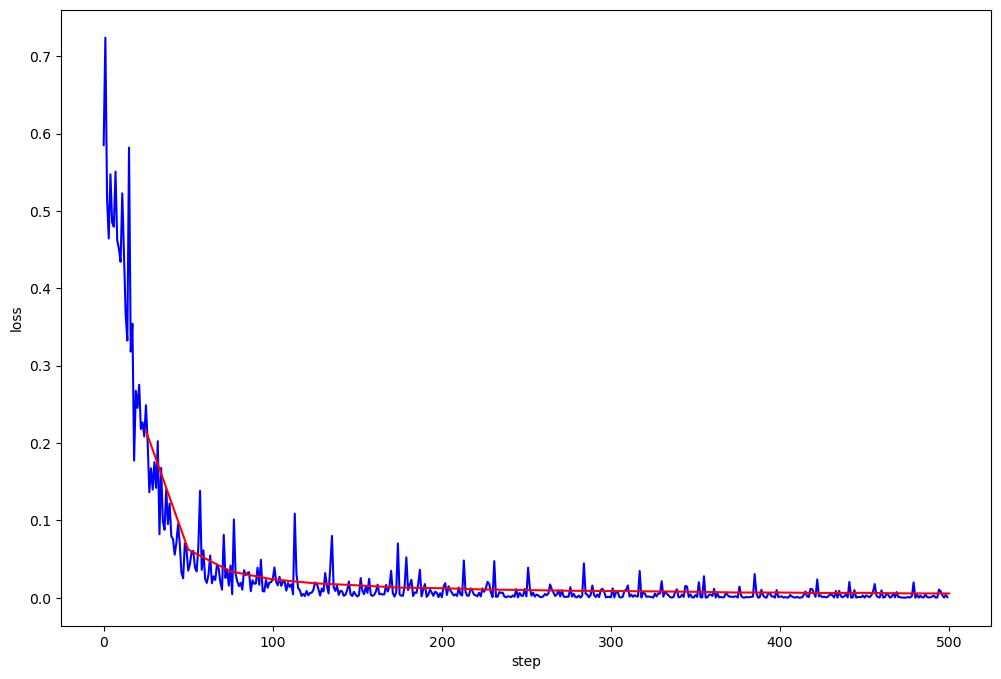

In [161]:
valid_loss_history = np.array(valid_loss_history)
train_loss_history =  np.array(train_loss_history)

plt.figure(figsize=(12,8))
plt.plot(train_loss_history[:,0],
         train_loss_history[:,1], color='blue')

plt.plot(valid_loss_history[:,0],
         valid_loss_history[:,1], color='red')
plt.xlabel("step")
plt.ylabel("loss")

#### Evaluation

In [162]:
model = best_model

model.eval()

total = 0
correct = 0
for batch in test_dataloader:
    x = torch.tensor(batch['x'])
    y = torch.tensor(batch['y'])
    y_pred = model(x)
    
    curr_correct = y_pred.argmax(dim=1) == y
    
    total += len(curr_correct)
    correct += sum(curr_correct)
    
print(f'test accuracy: {correct / total}')

test accuracy: 1.0
